In [1]:
#libraries
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer as MICE
from scipy.stats.mstats import winsorize

(CVXPY) Jul 03 03:59:23 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [2]:
#assign csv into a datframe
df = pd.read_csv("realtor-data.csv")

In [3]:
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [4]:
#a brief look at summary statistics of numerical variables
df.describe()

,bed,bath,acre_lot,zip_code,house_size,price
count,320108.000000,321618.000000,331873.000000,407693.000000,3.243650e+05,4.078900e+05
mean,3.500200,2.566545,17.418487,3299.396838,2.222783e+03,6.758307e+05
std,2.320135,2.391618,931.723094,2222.641467,3.333098e+03,1.178266e+06
min,1.000000,1.000000,0.000000,601.000000,1.000000e+02,1.000000e+00
25%,2.000000,2.000000,0.200000,1890.000000,1.206000e+03,1.999000e+05
50%,3.000000,2.000000,0.560000,2822.000000,1.767000e+03,3.979000e+05
75%,4.000000,3.000000,2.200000,4630.000000,2.640000e+03,7.090000e+05
max,99.000000,198.000000,100000.000000,99999.000000,1.450112e+06,6.000000e+07


##### From the summary statistics we can see potential outliers already. For example, houses with 99 beds is highly unlikely and worth investigating. The same goes for a house with 198 bathrooms and a house with 100,000 acres.

In [5]:
df.shape

(407890, 10)

In [6]:
#other variables are turned into categorical variables
#df[["status", "city", "state"]] = df[["status", "city", "state"]].astype("category")
#df.dtypes

In [7]:
#date conversion
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], format='%Y-%m-%d')

In [8]:
#counts for each cateegorical variable to determine posssible data
for column in ["status", "city", "state"]: 
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print()

Value counts for status:
status
for_sale          407130
ready_to_build       760
Name: count, dtype: int64

Value counts for city:
city
Boston                31502
San Juan               4788
Providence             4222
Springfield            3987
Worcester              3697
                      ...  
Big Moose Township        1
T3 R12 Wels               1
T13 R8 Wels               1
T11 R4 Wels               1
T6 R1 Nbpp                1
Name: count, Length: 1412, dtype: int64

Value counts for state:
state
Massachusetts     173479
New Hampshire      51394
Vermont            46460
Connecticut        38180
Maine              36650
Rhode Island       28518
Puerto Rico        24679
New York            5829
Virgin Islands      2573
Georgia               48
South Carolina        24
Tennessee             20
Virginia              20
New Jersey            13
Wyoming                3
Name: count, dtype: int64



In [9]:
#look for missing data
df.isnull().sum()

status                 0
bed                87782
bath               86272
acre_lot           76017
city                  52
state                  0
zip_code             197
house_size         83525
prev_sold_date    266940
price                  0
dtype: int64

<Axes: >

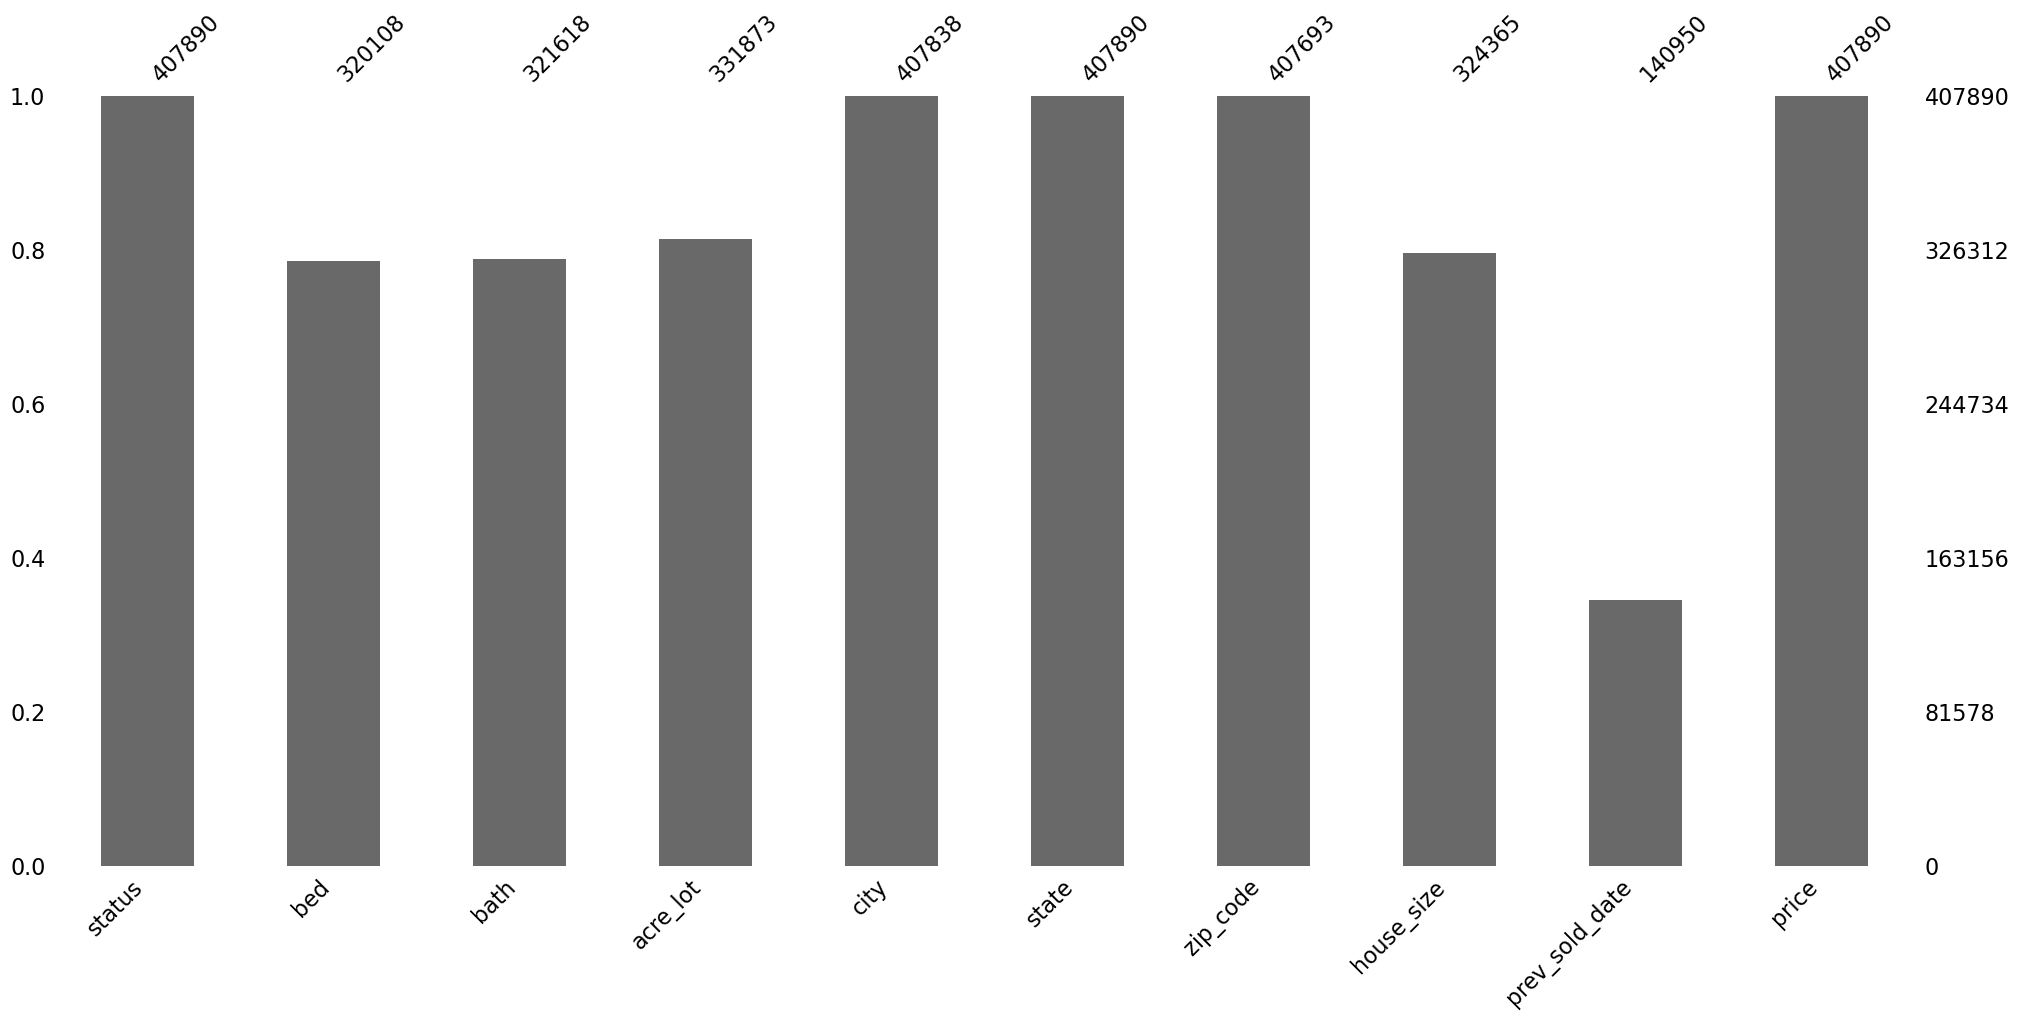

In [10]:
msno.bar(df) 

##### The graph shows that bed, bath, acre_lot and house_size have 20% missing data on average while prev_sold_date has approximately 60% missing. The most likely explanation is that only about 40% of the houses have been sold so far, we can consider the missing data "missing at random (MAR)".

##### In order to determine the nature of missing data of the other mentioned variables, I will do some visualization

<Axes: >

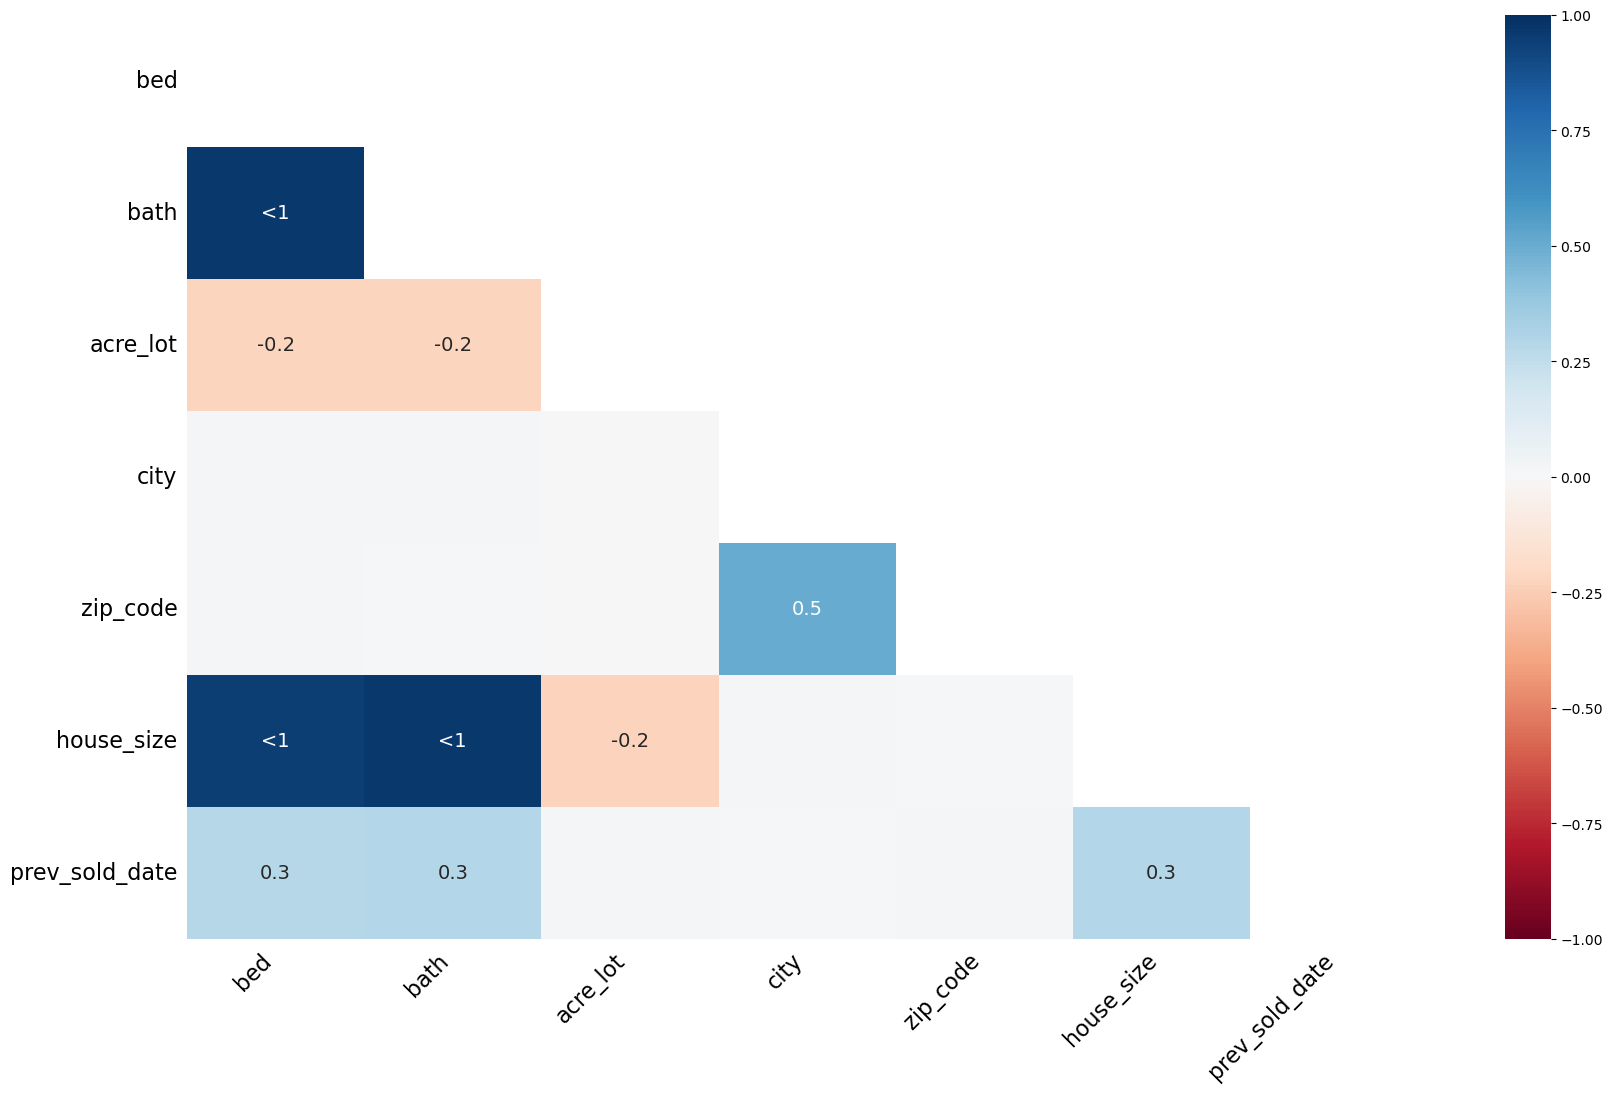

In [11]:
msno.heatmap(df)

##### making a heatmap of the missing variables, we find correlations between the missing data of each variables. According to msno documentation, a value of <1 means that two variables have a correlation close to 1 but not quite. In other words, If bed has data, it is likely bath will have missing data and vice versa. Bed and bath also have <1 when it comes to house size. From this information, we can deduce that the missing data is most likely MAR but because the correlation is close to 1 but not exactly 1, there might be other factors at play which causes the missing data.

##### Logically speaking, house sizes that are smaller could cause it to not have a bedroom or a bathroom and instead, have a singular multi-purpose room. Assuming data is MAR, I will use MICE in order to fill in the missing data. In reference to the correlation matrix, I will not be using "status", "city" and "states" in the imputation as they do not seem to affect variables with missing data in any meaningful way.

In [12]:
#store the dropped columns for later
status = df['status']
prev_sold_date = df['prev_sold_date']
city = df['city']
state = df['state']

#impute the miossing data from remaining columns
df_nocat = df.drop(['status','prev_sold_date', 'city', 'state'], axis=1)
df_imputed = MICE().fit_transform(df_nocat)

In [13]:
# Convert the result back to DataFrame
df_imputed = pd.DataFrame(df_imputed, columns = df_nocat.columns)

# Add the dropped columns back to the DataFrame
df_imputed['status'] = status.values
df_imputed['prev_sold_date'] = prev_sold_date.values
df_imputed['city'] = city.values
df_imputed['state'] = state.values

In [14]:
print(df_imputed.isnull().sum())

bed                    0
bath                   0
acre_lot               0
zip_code               0
house_size             0
price                  0
status                 0
prev_sold_date    266940
city                  52
state                  0
dtype: int64


In [15]:
df_imputed.head()

,bed,bath,acre_lot,zip_code,house_size,price,status,prev_sold_date,city,state
0,3.0,2.0,0.12,601.0,920.000000,105000.0,for_sale,NaT,Adjuntas,Puerto Rico
1,4.0,2.0,0.08,601.0,1527.000000,80000.0,for_sale,NaT,Adjuntas,Puerto Rico
2,2.0,1.0,0.15,795.0,748.000000,67000.0,for_sale,NaT,Juana Diaz,Puerto Rico
3,4.0,2.0,0.10,731.0,1800.000000,145000.0,for_sale,NaT,Ponce,Puerto Rico
4,6.0,2.0,0.05,680.0,2460.471951,65000.0,for_sale,NaT,Mayaguez,Puerto Rico


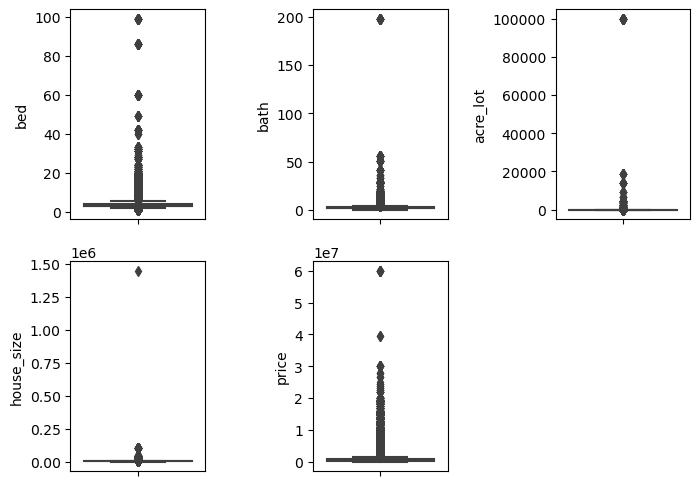

In [16]:
#boxplots of numerical variables
plt.figure(figsize=(8, 6))

plt.subplot(2, 3, 1)
sns.boxplot(y=df_imputed['bed'])

plt.subplot(2, 3, 2)
sns.boxplot(y=df_imputed['bath'])

plt.subplot(2, 3, 3)
sns.boxplot(y=df_imputed['acre_lot'])

plt.subplot(2, 3, 4)
sns.boxplot(y=df_imputed['house_size'])

plt.subplot(2, 3, 5)
sns.boxplot(y=df_imputed['price'])

plt.subplots_adjust(wspace=0.8) 
plt.show()

In [17]:
#check for numerical data distribution
#Fix outliers

In [18]:
#check for houses with over 90 bedrooms
df_imputed[df_imputed['bed'] > 90]

,bed,bath,acre_lot,zip_code,house_size,price,status,prev_sold_date,city,state
121247,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
121571,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
125572,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
128105,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
134625,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
141926,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
146399,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
149025,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
149861,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts
152119,99.0,198.0,0.29,2152.0,14462.0,5300000.0,for_sale,NaT,Winthrop,Massachusetts


##### Through some brief research, I have found the biggest property in USA to be the Biltmore Estate which has; 43 bathrooms, 34 bedrooms, 65 fireplaces, 8000 acres of land and 178,926 sq ft of area. Based on this information, I can deduce the upper limit on certain variables and determine which are outliers. To address them, I will winsorize the variables bed, bathroom, acre_lot and house_size.

In [19]:
# apply winsorizing to each column
columns = ['bed', 'bath', 'acre_lot', 'house_size']
for col in columns:
    df_imputed[col] = winsorize(df_imputed[col], limits=[0.001, 0.001])

In [24]:
df_imputed.head()

,bed,bath,acre_lot,zip_code,house_size,price,status,prev_sold_date,city,state
0,3.0,2.0,0.12,601.0,920.000000,105000.0,for_sale,NaT,Adjuntas,Puerto Rico
1,4.0,2.0,0.08,601.0,1527.000000,80000.0,for_sale,NaT,Adjuntas,Puerto Rico
2,2.0,1.0,0.15,795.0,748.000000,67000.0,for_sale,NaT,Juana Diaz,Puerto Rico
3,4.0,2.0,0.10,731.0,1800.000000,145000.0,for_sale,NaT,Ponce,Puerto Rico
4,6.0,2.0,0.05,680.0,2460.471951,65000.0,for_sale,NaT,Mayaguez,Puerto Rico


<Axes: >

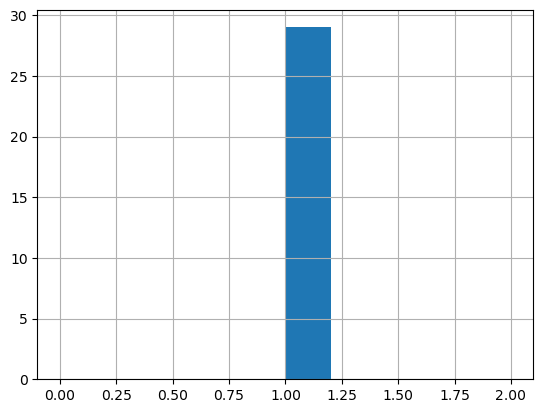

In [23]:
df_imputed['price'].hist(range =[0,2])